In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import cv2

from keras.applications import VGG16
from keras.datasets import cifar10
from keras.models import load_model
from keras.utils import to_categorical
from keras import backend as K

from cleverhans.attacks import FastGradientMethod, LBFGS
from cleverhans.utils_keras import KerasModelWrapper

from vis.utils import utils
from vis.visualization import visualize_saliency, visualize_cam, overlay

Using TensorFlow backend.


https://jacobgil.github.io/deeplearning/class-activation-maps

In [2]:
def overlay(img, heatmap, intensity=0.4):
    # cv2 uses BGR order
    img = img[:, :, ::-1].copy()
    
    heatmap = cv2.resize(heatmap, img.shape[:2])
    heatmap = np.uint8(heatmap * 255)
    img = np.uint8(img * 255)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = np.uint8(heatmap * intensity + img)
    plt.imshow(overlay[:,:,::-1])

#overlay(sample_imgs[6], heatmap, intensity=0.3)

def grad_cam(model, img, label, conv_layer_idx, process=False, my_process=False):
    if len(img.shape) == 3:
        img = np.expand_dims(img, axis=0)
    elif len(img.shape) != 4:
        raise ValueError('img not shape (1, w, h, 3)')
    
    class_output = model.output[:, label]
    last_conv_layer = model.layers[conv_layer_idx]
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    #print('Pooled grads:', pooled_grads.shape[0])
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img])

    for i in range(pooled_grads.shape[0]): # 512
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    if process:
        #print(heatmap.max())
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / heatmap.max()
        heatmap = cv2.resize(heatmap, (32, 32))
    elif my_process:
        heatmap = heatmap + abs(heatmap.min())
        heatmap = heatmap / heatmap.max()
        heatmap = cv2.resize(heatmap, (32, 32))
    
    return heatmap

def plot_pair(img, adv, model=None):
    if len(img.shape) != 3 or len(adv.shape) != 3:
        raise ValueError("Image shape must have len 3")
    
    if model:
        img_pred = np.argmax(model.predict(img.reshape(1, 32, 32, 3)))
        adv_pred = np.argmax(model.predict(adv.reshape(1, 32, 32, 3)))
        img_pred = CIFAR10_LABEL_NAMES[img_pred]
        adv_pred = CIFAR10_LABEL_NAMES[adv_pred]
    
    diff = img - adv
    diff = diff + abs(diff.min())
    diff = diff / diff.max()
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 9))
    axs[0].imshow(img)
    axs[1].imshow(diff)
    axs[2].imshow(adv)
    
    if model:
        axs[0].set_title("Original Image" + "\nPred: " + img_pred)
        axs[1].set_title("Difference")
        axs[2].set_title("Adversarial Image" + "\nPred: " + adv_pred)
    else:
        axs[0].set_title("Original Image")
        axs[1].set_title("Difference")
        axs[2].set_title("Adversarial Image")

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

y_test_tmp = np.squeeze(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [4]:
model = load_model('../Saved_models/cifar10_vgg_like_175.h5')

In [5]:
model.evaluate(x_train, y_train)

50000/50000 [==============================] - 6s 123us/step


[0.2980662244796753, 0.93516]

In [6]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 111us/step


[0.44281897659301755, 0.8906]

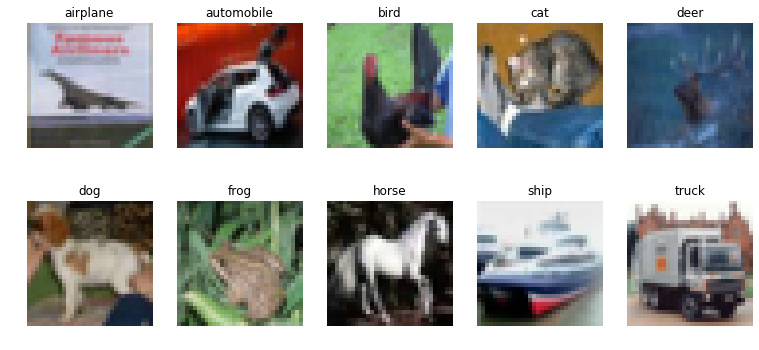

In [7]:
label_names = {0: 'airplane',
               1: 'automobile',
               2: 'bird',
               3: 'cat',
               4: 'deer',
               5: 'dog',
               6: 'frog',
               7: 'horse',
               8: 'ship',
               9: 'truck'}

sample_imgs = []
num_classes = 10
f, axs = plt.subplots(2, 5, figsize=(13, 6))
for i, x in enumerate(divmod(i, 5) for i in range(num_classes)):
    img = x_test[np.argmax((y_test_tmp == i))].copy()
    sample_imgs.append(img)
    axs[x].imshow(img)
    axs[x].set_title(label_names[i])
    axs[x].axis('off')

sample_imgs = np.array(sample_imgs, dtype='float32')

In [8]:
np.argmax(model.predict(sample_imgs), axis=0)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
model.layers[19:27]

In [10]:
model.layers[20]

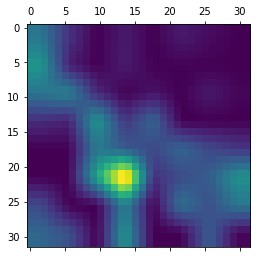

In [11]:
i = 5
last_conv_idx = 20
heatmap = grad_cam(model, sample_imgs[i], i, last_conv_idx, process=True)

plt.matshow(heatmap)

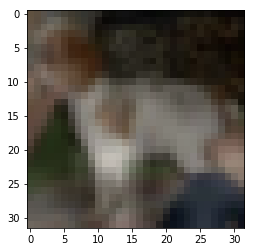

In [12]:
heatmap = cv2.resize(heatmap, (32, 32))
plt.imshow(sample_imgs[i])
plt.imshow(heatmap, cmap='gray', alpha=0.5)

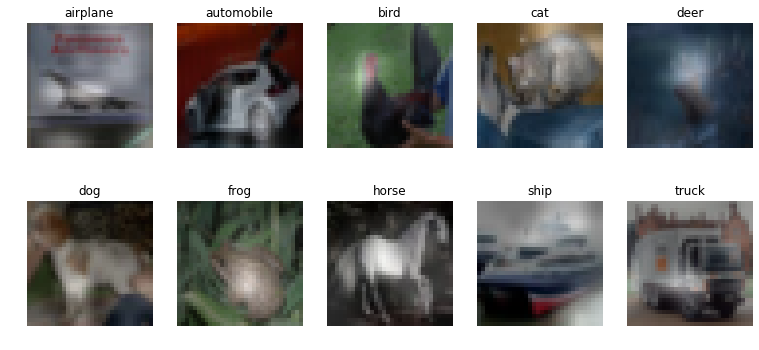

In [13]:
f, axs = plt.subplots(2, 5, figsize=(13, 6))
for i, x in enumerate(divmod(i, 5) for i in range(num_classes)):
    img = sample_imgs[i]
    hm = grad_cam(model, img, i, last_conv_idx, process=True)
    axs[x].imshow(img)
    axs[x].imshow(hm, cmap='gray', alpha=0.5)
    axs[x].set_title(label_names[i])
    axs[x].axis('off')

In [14]:
K.set_learning_phase(0)
ch_model = KerasModelWrapper(model)

In [15]:
fgsm = FastGradientMethod(ch_model, sess=K.get_session())
# eps = 0.025
fgsm_params = {'eps': 0.025,
               'clip_min': 0,
               'clip_max': 1}

In [16]:
adv = fgsm.generate_np(sample_imgs, **fgsm_params)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



[0 9 0 2 6 3 4 7 6 1]


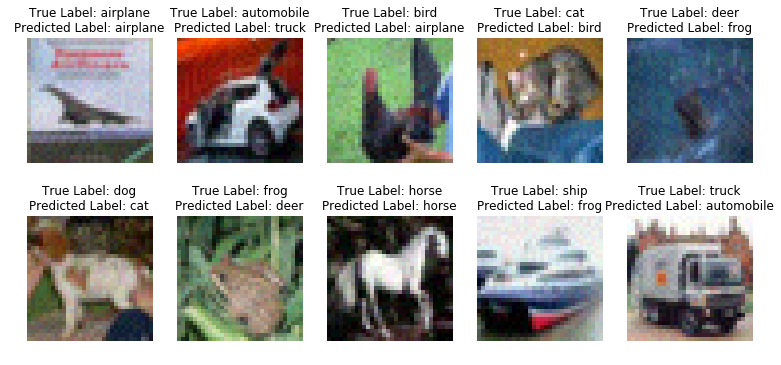

In [17]:
pred = np.argmax(model.predict(adv), axis=0)
print(pred)
f, axs = plt.subplots(2, 5, figsize=(13, 6))
for i, x in enumerate(divmod(i, 5) for i in range(num_classes)):
    img = adv[i]
    #hm = grad_cam(model, img, i, last_conv_idx, process=True)
    axs[x].imshow(img)
    #axs[x].imshow(hm, cmap='gray', alpha=0.5)
    axs[x].set_title('True Label: ' + str(label_names[i]) + '\n' + 'Predicted Label: ' + str(label_names[pred[i]]))
    axs[x].axis('off')

/home/calvin/python3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/home/calvin/python3/lib/python3.5/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/calvin/python3/lib/python3.5/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/calvin/python3/lib/python3.5/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/calvin/python3/lib/python3.5/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/calvin/python3/lib/python3.5/site-packages/matplotlib/colors.py:902: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/calvin/python3/lib/python3.5/site-packag

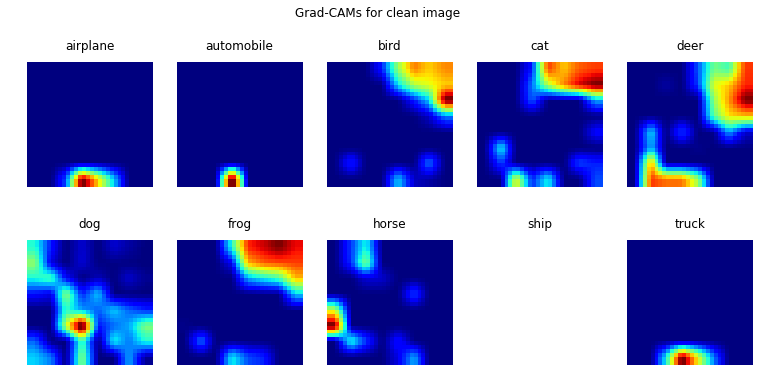

In [18]:
f, axs = plt.subplots(2, 5, figsize=(13, 6))
f.suptitle('Grad-CAMs for clean image')
for i, x in enumerate(divmod(i, 5) for i in range(num_classes)):
    hm = grad_cam(model, sample_imgs[5], i, last_conv_idx, process=True)
    axs[x].matshow(hm, cmap='jet')
    #axs[x].imshow(hm, cmap='gray', alpha=0.5)
    axs[x].set_title(label_names[i])
    axs[x].axis('off')
# hm = grad_cam(model, sample_imgs[5], 8, last_conv_idx, my_process=True)
# plt.imshow(hm, cmap='jet')

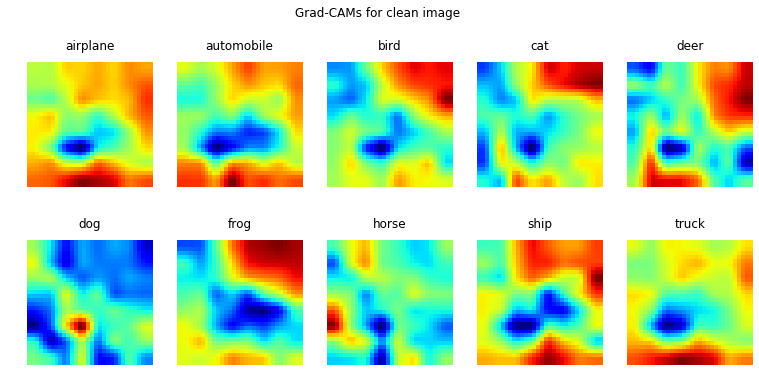

In [19]:
f, axs = plt.subplots(2, 5, figsize=(13, 6))
f.suptitle('Grad-CAMs for clean image')
for i, x in enumerate(divmod(i, 5) for i in range(num_classes)):
    hm = grad_cam(model, sample_imgs[5], i, last_conv_idx, my_process=True)
    axs[x].matshow(hm, cmap='jet')
    #axs[x].imshow(hm, cmap='gray', alpha=0.5)
    axs[x].set_title(label_names[i])
    axs[x].axis('off')
# hm = grad_cam(model, sample_imgs[5], 8, last_conv_idx, my_process=True)
# plt.imshow(hm, cmap='jet')

/home/calvin/python3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


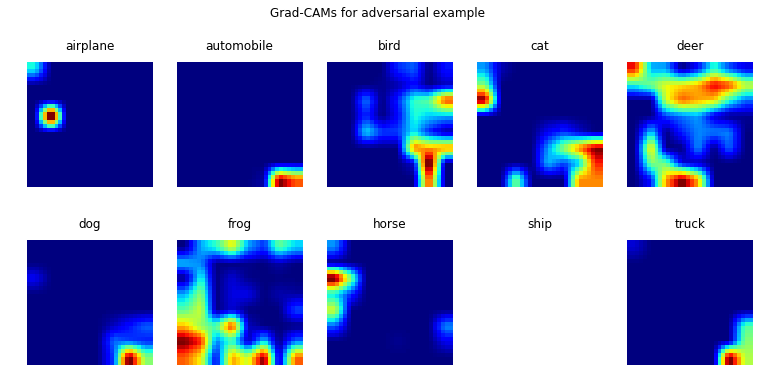

In [20]:
f, axs = plt.subplots(2, 5, figsize=(13, 6))
f.suptitle('Grad-CAMs for adversarial example')
for i, x in enumerate(divmod(i, 5) for i in range(num_classes)):
    hm = grad_cam(model, adv[5], i, last_conv_idx, process=True)
    axs[x].matshow(hm, cmap='jet')
    #axs[x].imshow(hm, cmap='gray', alpha=0.5)
    axs[x].set_title(label_names[i])
    axs[x].axis('off')

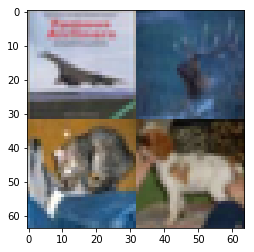

In [21]:
tmp1 = np.vstack((sample_imgs[0], sample_imgs[3]))
tmp2 = np.vstack((sample_imgs[4], sample_imgs[5]))
grid = np.hstack((tmp1, tmp2))
plt.imshow(grid)

In [22]:
grid = cv2.resize(grid, (32, 32))

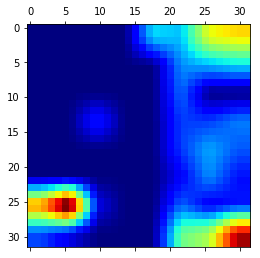

In [23]:
hm = grad_cam(model, grid, 5, last_conv_idx, process=True)
plt.matshow(hm, cmap='jet')

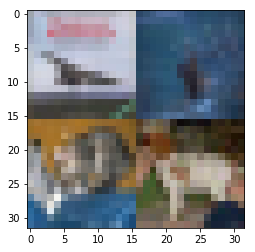

In [24]:
tmp1 = np.vstack((sample_imgs[0], sample_imgs[3]))
tmp2 = np.vstack((sample_imgs[4], adv[5]))
grid = np.hstack((tmp1, tmp2))
grid = cv2.resize(grid, (32, 32))
plt.imshow(grid)

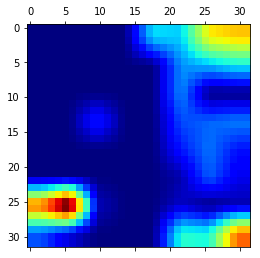

In [25]:
hm = grad_cam(model, grid, 5, last_conv_idx, process=True)
plt.matshow(hm, cmap='jet')

In [26]:
label_names[np.argmax(model.predict(np.expand_dims(grid, axis=0)))]

'truck'